In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

PREFIX = 'figures/Fig2C.'
FUNCTIONAL_ENRICHMENT_RESULTS_PATH = '../../manuscript-intermediate-processing/notebooks/tables'
TEXTWRAP = 25

palette = {'cis-eQTL': '#377eb8', 'cis-sQTL': '#e41a1c', 'trans-eQTL': '#4daf4a', 'trans-sQTL': '#984ea3'}

In [2]:
results = pd.read_csv(os.path.join(FUNCTIONAL_ENRICHMENT_RESULTS_PATH, 'calculate-functional-enrichments-set-level-logistic-regression.enrichments-vs-control-variants.tsv'), sep='\t', index_col=0)
results = results.rename(columns={'Coef.': 'coef', 'P>|z|': 'p', '[0.025': 'ci_lower', '0.975]': 'ci_upper', 'annotation': 'src', 'maf_threshold': 'maf'})
results.src = results.src.map(lambda x: 'roadmap' if 'roadmap' in x else x).map({'roadmap': 'chromatin states', 'snpeff': 'SnpEff', 'regulatory_build': 'Ensembl regulatory build'})
results = results[results.src!='Ensembl regulatory build']
results['annotation'] = results.index.str.replace('_', ' ').str.capitalize().str.wrap(TEXTWRAP)
results = results[(results.annotation!='Const') & (results.maf!='0.1%') & (results.converged) & (results.modality.str.contains('cis'))]
results['p_corrected'] = multipletests(results.p, method='Bonferroni')[1]
results.head()

,coef,Std.Err.,z,p,ci_lower,ci_upper,converged,n_hits_in_annotation,n_hits_not_in_annotation,n_controls_in_annotation,n_controls_not_in_annotation,tissue,modality,maf,src,annotation,p_corrected
sequence_feature,-0.078589,0.048185,-1.630979,1.028947e-01,-0.173030,0.015852,True,1335,23744,838,24241,Lung,cis-eQTL,1%,SnpEff,Sequence feature,1.000000e+00
5_prime_UTR_variant,0.648394,0.039557,16.391570,2.196965e-60,0.570864,0.725923,True,3798,21281,1315,23764,Lung,cis-eQTL,1%,SnpEff,5 prime utr variant,6.656803e-58
3_prime_UTR_variant,0.326662,0.028733,11.369052,5.963155e-30,0.270347,0.382976,True,6034,19045,2990,22089,Lung,cis-eQTL,1%,SnpEff,3 prime utr variant,1.806836e-27
intron_variant,0.166290,0.027745,5.993512,2.053564e-09,0.111911,0.220670,True,20532,4547,17018,8061,Lung,cis-eQTL,1%,SnpEff,Intron variant,6.222298e-07
downstream_gene_variant,0.272838,0.022563,12.092274,1.160295e-33,0.228615,0.317060,True,16615,8464,11696,13383,Lung,cis-eQTL,1%,SnpEff,Downstream gene variant,3.515692e-31


In [3]:
KEEP_ANNOTATIONS = [
    'intergenic_region', 
    'TF_binding_site_variant', 
    '5_prime_UTR_variant', 
    'intron_variant', 
    'splice_region_variant', 
    'missense_variant', 
    '3_prime_UTR_variant', 
    'Enhancers', 
    'Active_TSS', 
    'Strong transcription',
    'Quiescent/Low']

ANNOTATION_NAMES = {
    'intergenic_region': 'Intergenic', 
    'TF_binding_site_variant': 'TF binding site', 
    '5_prime_UTR_variant': "5' UTR", 
    'intron_variant': 'Intron', 
    'splice_region_variant': 'Splice region', 
    'missense_variant': 'Missense', 
    '3_prime_UTR_variant': "3' UTR",
    'Enhancers': 'Enhancers', 
    'Active_TSS': 'Active TSS', 
    'Strong transcription': 'Strong transcription',
    'Quiescent/Low': 'Quiescent'
}


df_cis = results[results.tissue=='Whole_blood'].loc[KEEP_ANNOTATIONS]
df_cis.annotation = df_cis.index
palette = {'cis-eQTL': '#377eb8', 'cis-sQTL': '#e41a1c'}

df_snpeff = df_cis[df_cis.src=='SnpEff']
df_roadmap = df_cis[df_cis.src=='chromatin states']


/tmp/ipykernel_3427248/1469684382.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


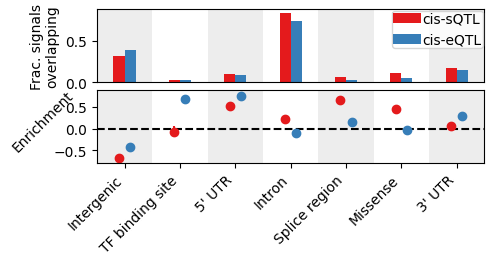

In [4]:

fig, axs = plt.subplots(nrows=2, figsize=(5, 2), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

dodge = {'cis-eQTL': 0.1, 'cis-sQTL': -0.1}

# add alternating background colors
xmin = 0
xmax = df_snpeff.annotation.nunique() - 1
x = xmin
while x < xmax+1:
    axs[0].axvspan(x-0.5, x+0.5, facecolor='lightgrey', alpha=0.4)
    axs[1].axvspan(x-0.5, x+0.5, facecolor='lightgrey', alpha=0.4)
    x += 2

x_variable_to_x = dict([[j, i] for i, j in enumerate(df_snpeff.annotation.unique())])
df_mod = df_snpeff.copy()
df_mod['x'] = df_mod['annotation'].map(x_variable_to_x) + df_mod['modality'].map(dodge)
df_mod['ci_lower'] = df_mod['coef'] - df_mod['ci_lower']
df_mod['ci_upper'] = df_mod['ci_upper'] - df_mod['coef']
for h, df2 in df_mod.groupby('modality'):
    axs[1].errorbar(x=df2['x'], y=df2['coef'], yerr=df2[['ci_lower', 'ci_upper']].values.T, fmt='o', color=palette[h], label=h)
axs[1].set_xticks(range(0, len(x_variable_to_x)))
axs[1].set_xticklabels([ANNOTATION_NAMES[i] for i in df_mod['annotation'].unique()], rotation=45, va='top', ha='right')
axs[1].axhline(0, color='black', ls='--')
axs[1].set_ylabel('Enrichment', rotation=45, labelpad=4)
axs[1].set_xlim(xmin-0.5, xmax+0.5)

# barplot
df_mod['frac'] = df_mod.n_hits_in_annotation / df_mod[['n_hits_in_annotation', 'n_hits_not_in_annotation']].sum(axis=1)
df_mod['perc'] = df_mod['frac'] * 100
for h, df2 in df_mod.groupby('modality'):
    axs[0].bar(x=df2['x'], height=df2['frac'], width=0.2, color=palette[h], label=h)
axs[0].set_xticks([])
axs[0].set_xlim(xmin-0.5, xmax+0.5)
axs[0].set_ylabel('Frac. signals\noverlapping')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[::-1], labels[::-1], columnspacing=0.5, handletextpad=0.1, borderpad=0.1, borderaxespad=0.1)


fig.tight_layout()
fig.savefig(f'{PREFIX}snpeff.png', dpi=300, facecolor='white', bbox_inches='tight')

/tmp/ipykernel_3427248/2205855778.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


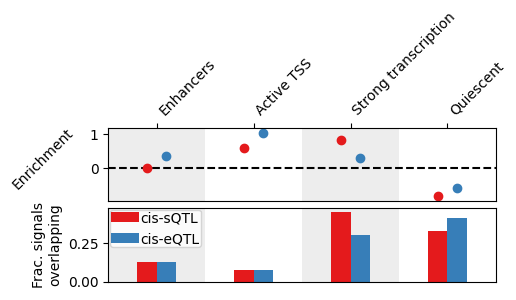

In [5]:

fig, axs = plt.subplots(nrows=2, figsize=(5, 2), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})

dodge = {'cis-eQTL': 0.1, 'cis-sQTL': -0.1}

# add alternating background colors
xmin = 0
xmax = df_roadmap.annotation.nunique() - 1
x = xmin
while x < xmax+1:
    axs[0].axvspan(x-0.5, x+0.5, facecolor='lightgrey', alpha=0.4)
    axs[1].axvspan(x-0.5, x+0.5, facecolor='lightgrey', alpha=0.4)
    x += 2

x_variable_to_x = dict([[j, i] for i, j in enumerate(df_roadmap.annotation.unique())])
df_mod = df_roadmap.copy()
df_mod['x'] = df_mod['annotation'].map(x_variable_to_x) + df_mod['modality'].map(dodge)
df_mod['ci_lower'] = df_mod['coef'] - df_mod['ci_lower']
df_mod['ci_upper'] = df_mod['ci_upper'] - df_mod['coef']
for h, df2 in df_mod.groupby('modality'):
    axs[0].errorbar(x=df2['x'], y=df2['coef'], yerr=df2[['ci_lower', 'ci_upper']].values.T, fmt='o', color=palette[h], label=h)
axs[0].set_xticks(range(0, len(x_variable_to_x)))
axs[0].set_xticklabels([ANNOTATION_NAMES[i] for i in df_mod['annotation'].unique()], rotation=45, va='bottom', ha='left')
axs[0].axhline(0, color='black', ls='--')
axs[0].set_ylabel('Enrichment', rotation=45, labelpad=30)
axs[0].set_xlim(xmin-0.5, xmax+0.5)
axs[0].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

# barplot
df_mod['frac'] = df_mod.n_hits_in_annotation / df_mod[['n_hits_in_annotation', 'n_hits_not_in_annotation']].sum(axis=1)
df_mod['perc'] = df_mod['frac'] * 100
for h, df2 in df_mod.groupby('modality'):
    axs[1].bar(x=df2['x'], height=df2['frac'], width=0.2, color=palette[h], label=h)
axs[1].set_xticks([])
axs[1].set_xlim(xmin-0.5, xmax+0.5)
axs[1].set_ylabel('Frac. signals\noverlapping')
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles[::-1], labels[::-1], columnspacing=0.5, handletextpad=0.1, borderpad=0.1, borderaxespad=0.1)

fig.tight_layout()
fig.savefig(f'{PREFIX}roadmap.png', dpi=300, facecolor='white', bbox_inches='tight')